In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import umap
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import time
from datetime import timedelta
#import torch_optimizer as optim

try:
    from cuml.accel import install
    install()
except ImportError:
    print("Cuml not installed, using CPU for umap and sklearn")

from src import RepresentationLayer, DGD, ConvDecoder, LatentSpaceVisualizer, GaussianMixture, plot_training_losses, plot_images, plot_gmm_images, plot_gmm_samples

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch CUDA version: {torch.version.cuda}")
print(f"PyTorch version: {torch.__version__}")

if device.type == 'cuda':
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory Allocated: {torch.cuda.memory_allocated(i)/1024**2} MB")
        print(f"  Memory Reserved: {torch.cuda.memory_reserved(i)/1024**2} MB")
        print(f"  Total Memory: {torch.cuda.get_device_properties(i).total_memory/1024**2} MB")
    device = torch.device('cuda:0')
    torch.cuda.set_device(device)

RANDOM_STATE = 0
use_small_dataset = False

print('Using device:', device)

cuML: Installed accelerator for sklearn.
cuML: Installed accelerator for umap.
cuML: Successfully initialized accelerator.
PyTorch CUDA version: 12.6
PyTorch version: 2.7.0+cu126
Number of CUDA devices: 1
Device 0: NVIDIA GeForce RTX 4060 Laptop GPU
  Memory Allocated: 0.0 MB
  Memory Reserved: 0.0 MB
  Total Memory: 7805.5625 MB
Using device: cuda:0
PyTorch CUDA version: 12.6
PyTorch version: 2.7.0+cu126
Number of CUDA devices: 1
Device 0: NVIDIA GeForce RTX 4060 Laptop GPU
  Memory Allocated: 0.0 MB
  Memory Reserved: 0.0 MB
  Total Memory: 7805.5625 MB
Using device: cuda:0


In [2]:
# Load the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

class IndexedDataset(Dataset):
    def __init__(self, dataset, use_subset=False, subset_fraction=0.1):
        """
        Wrap a dataset with indices
        
        Parameters:
        ----------
        dataset: The original dataset
        use_subset: Whether to use only a subset of the data
        subset_fraction: The fraction of data to use if use_subset is True
        """
        self.dataset = dataset
        
        if use_subset:
            # Create a subset of indices (10% by default)
            total_size = len(dataset)
            subset_size = int(total_size * subset_fraction)
            
            # Create random indices ensuring we get samples from all classes
            all_indices = list(range(total_size))
            np.random.shuffle(all_indices)
            self.indices = all_indices[:subset_size]
        else:
            # Use all indices
            self.indices = list(range(len(dataset)))
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, index):
        # Map the index to the original dataset index
        orig_index = self.indices[index]
        data, target = self.dataset[orig_index]
        return orig_index, data, target

# Create datasets with the option to use only a subset
indexed_train_dataset = IndexedDataset(train_dataset, use_subset=use_small_dataset)
indexed_test_dataset = IndexedDataset(test_dataset, use_subset=use_small_dataset)

# Adjust batch size if using a small dataset
batch_size = 128
if use_small_dataset:
    # Use smaller batch size for small datasets
    batch_size = min(batch_size, max(32, len(indexed_train_dataset) // 10))
    print(f"Using small dataset, adjusted batch size: {batch_size}")

train_loader = DataLoader(indexed_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(indexed_test_dataset, batch_size=batch_size, shuffle=True)

# Print dataset info
print('Train dataset:', len(indexed_train_dataset), 
      f'({"10% of " if use_small_dataset else ""}total: {len(train_dataset)})')
print('Test dataset:', len(indexed_test_dataset), 
      f'({"10% of " if use_small_dataset else ""}total: {len(test_dataset)})')

# Print shape of an image
print('Image shape:', train_dataset[0][0].shape)
# Print total number of pixels in an image
print('Image size:', train_dataset[0][0].numel())

all_labels = torch.tensor([train_dataset[i][1] for i in indexed_train_dataset.indices], device=device)

# Get a batch of images and labels
batch_train = next(iter(train_loader))
indices_train, images_train, labels_train = batch_train

batch_test = next(iter(test_loader))
indices_test, images_test, labels_test = batch_test

# Plot the images with their labels
plot_images(images_train, labels_train, 'Fashion MNIST Train samples', epoch=None, cmap='viridis')
plot_images(images_test, labels_test, 'Fashion MNIST Test samples', epoch=None, cmap='viridis')

Train dataset: 60000 (total: 60000)
Test dataset: 10000 (total: 10000)
Image shape: torch.Size([1, 28, 28])
Image size: 784


🔬 Experiment: uniform_ball_r0.1_epochs200
📁 Figures will be saved to: figures/uniform_ball_r0.1_epochs200/
Decoder parameters: 246,945 (0.25M)
Train representation parameters: 300,000 (0.30M)
Test representation parameters: 50,000 (0.05M)
Total trainable parameters: 596,945 (0.60M)

Parameter distribution:
Decoder: 45.1%
Train rep: 54.9%

=== Training Configuration ===
Epochs: 200
Device: cuda:0
First GMM epoch: 50
Plot interval: 50
Using subset: False
Verbose mode: True
Initializing GMM at epoch 1...


/home/asp/Downloads/HeaDS/ImageDGD/src/models/gmm.py:752: UserWarning: EM algorithm did not converge. Try increasing max_iter or lowering tol.
  warnings.warn("EM algorithm did not converge. Try increasing max_iter or lowering tol.", UserWarning)
/home/asp/Downloads/HeaDS/ImageDGD/src/models/gmm.py:689: UserWarning: EM algorithm did not converge. Try increasing max_iter or lowering tol.
  warnings.warn("EM algorithm did not converge. Try increasing max_iter or lowering tol.", UserWarning)


Epoch 1/200 [TPE: 0:00:25, RT: 1:23:14]; Train Loss: 69.1948 (0.00%), Test Loss: 68.0370 (0.00%), Recon Train: 69.1948 (0.00%), Recon Test: 68.0370 (0.00%), GMM Train: 0.0000 (0.00%), GMM Test: 0.0000 (0.00%)
Unused keyword parameter: max_iter during cuML estimator initialization
# of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
Unused keyword parameter: max_iter during cuML estimator initialization
# of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
build_algo set to brute_force_knn because random_state is given
build_algo set to brute_force_knn because random_state is given
Epoch 2/200 [TPE: 0:00:23, RT: 1:20:17]; Train Loss: 66.6791 (3.64%), Test Loss: 65.7659 (3.34%), Recon Train: 66.6791 (3.64%), Recon Test: 65.7659 (3.34%), GMM Train: 0.0000 (0.00%), GMM Test: 0.0000 (0.00%)
Epoch 2/200 [TPE: 0:00:23, RT: 1:20:17]; Train Loss: 66.6791 (3.64%), Test Loss: 65.7659 (3.34%), Recon Train: 66.67

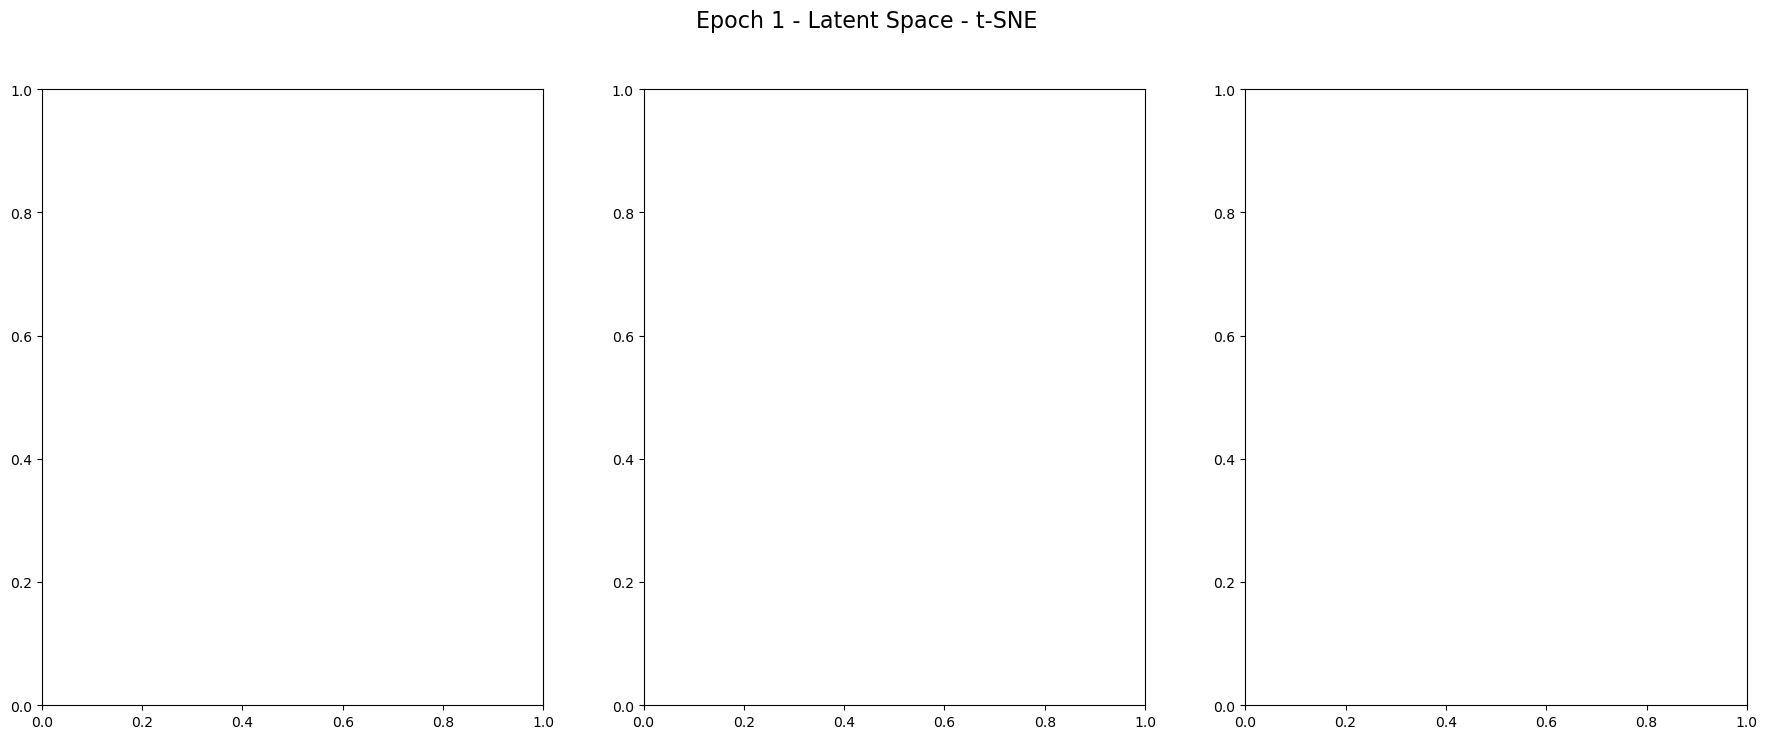

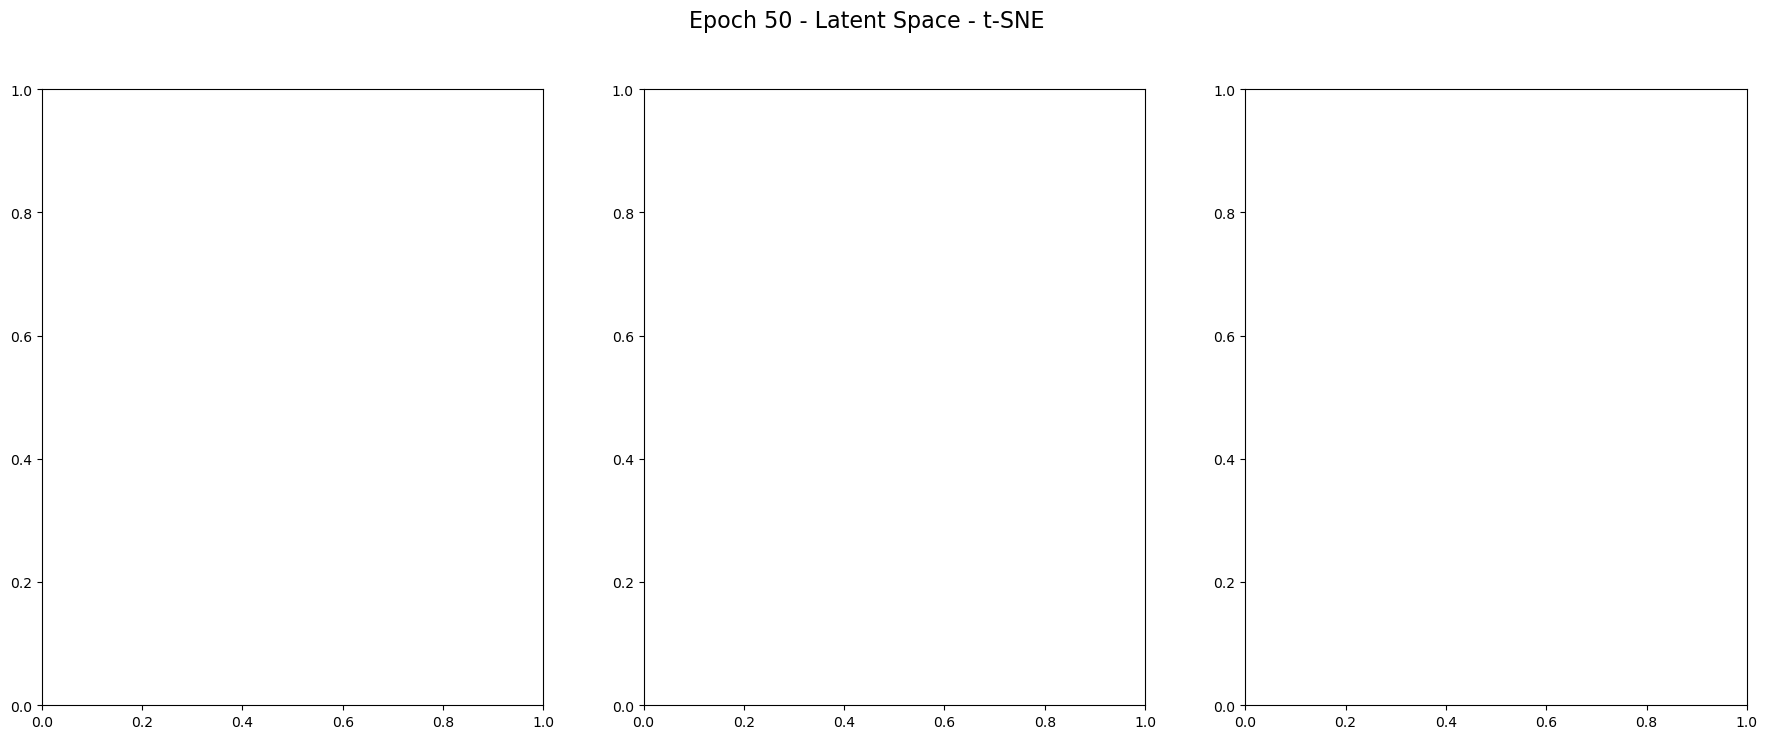

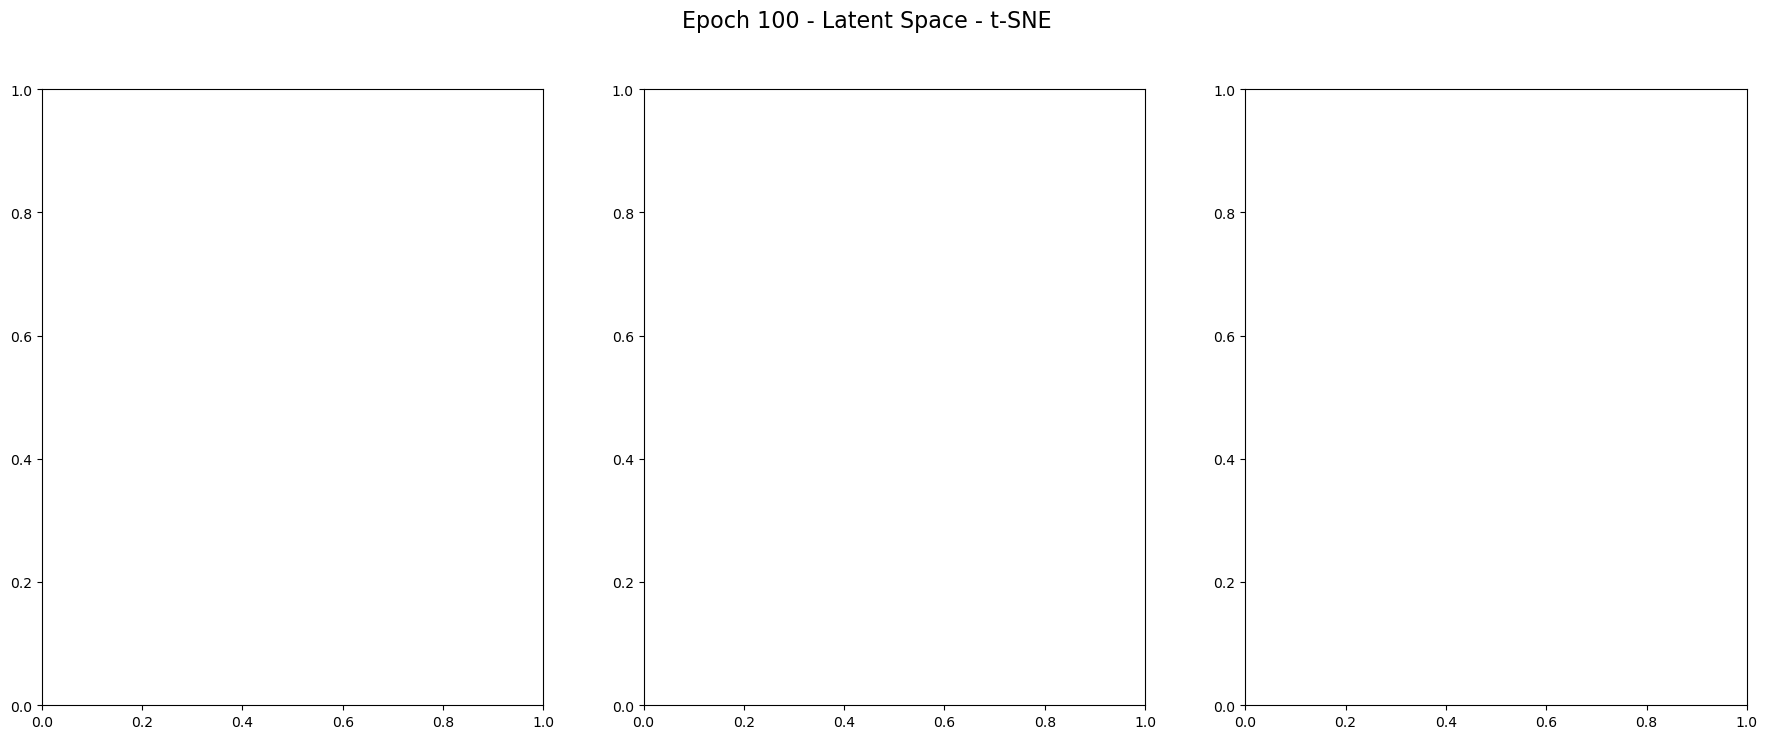

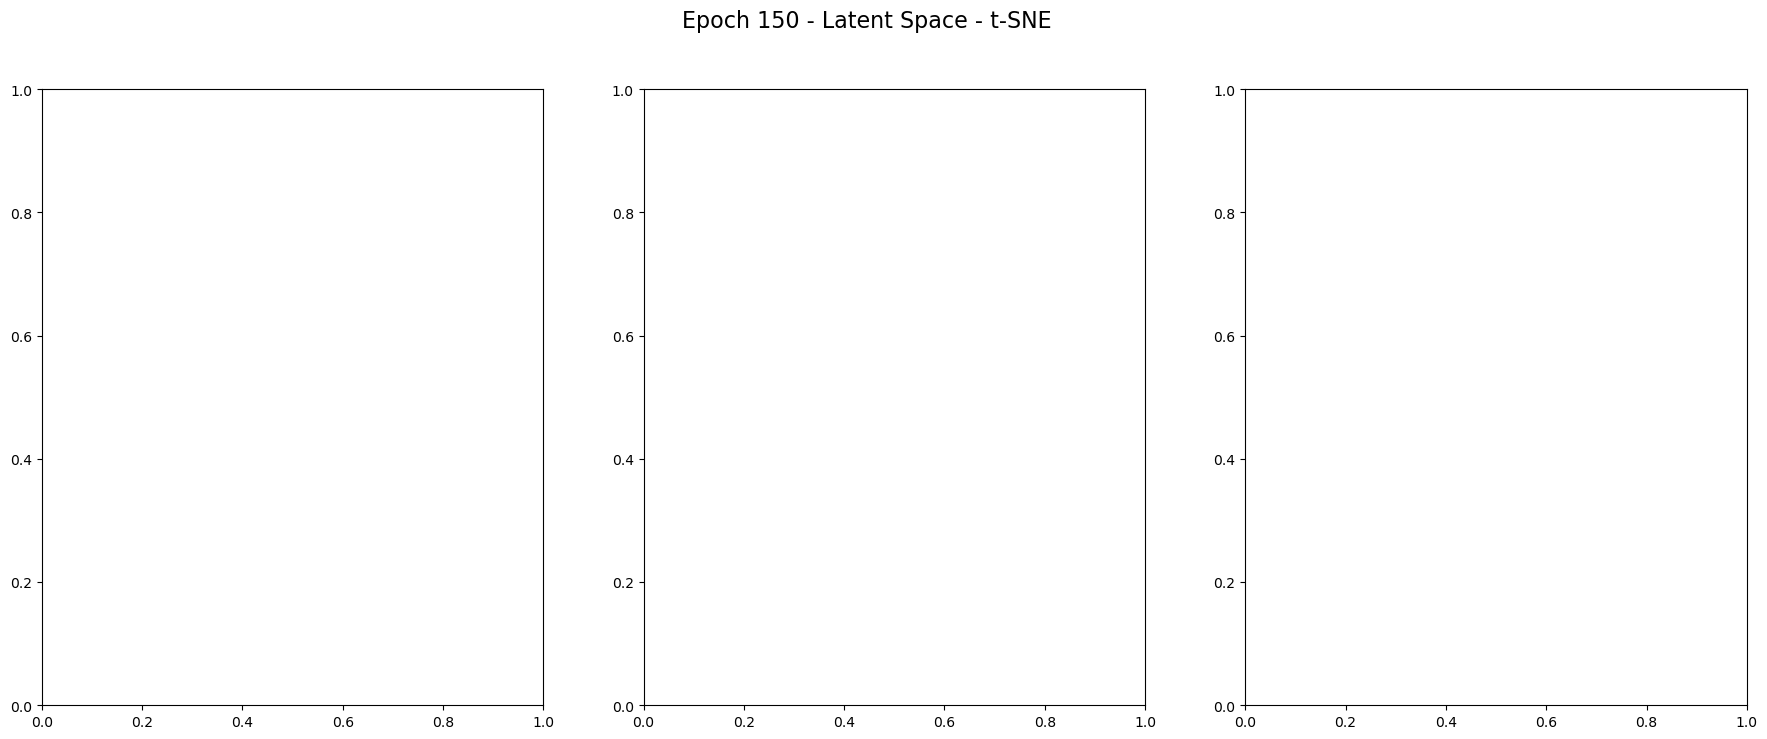

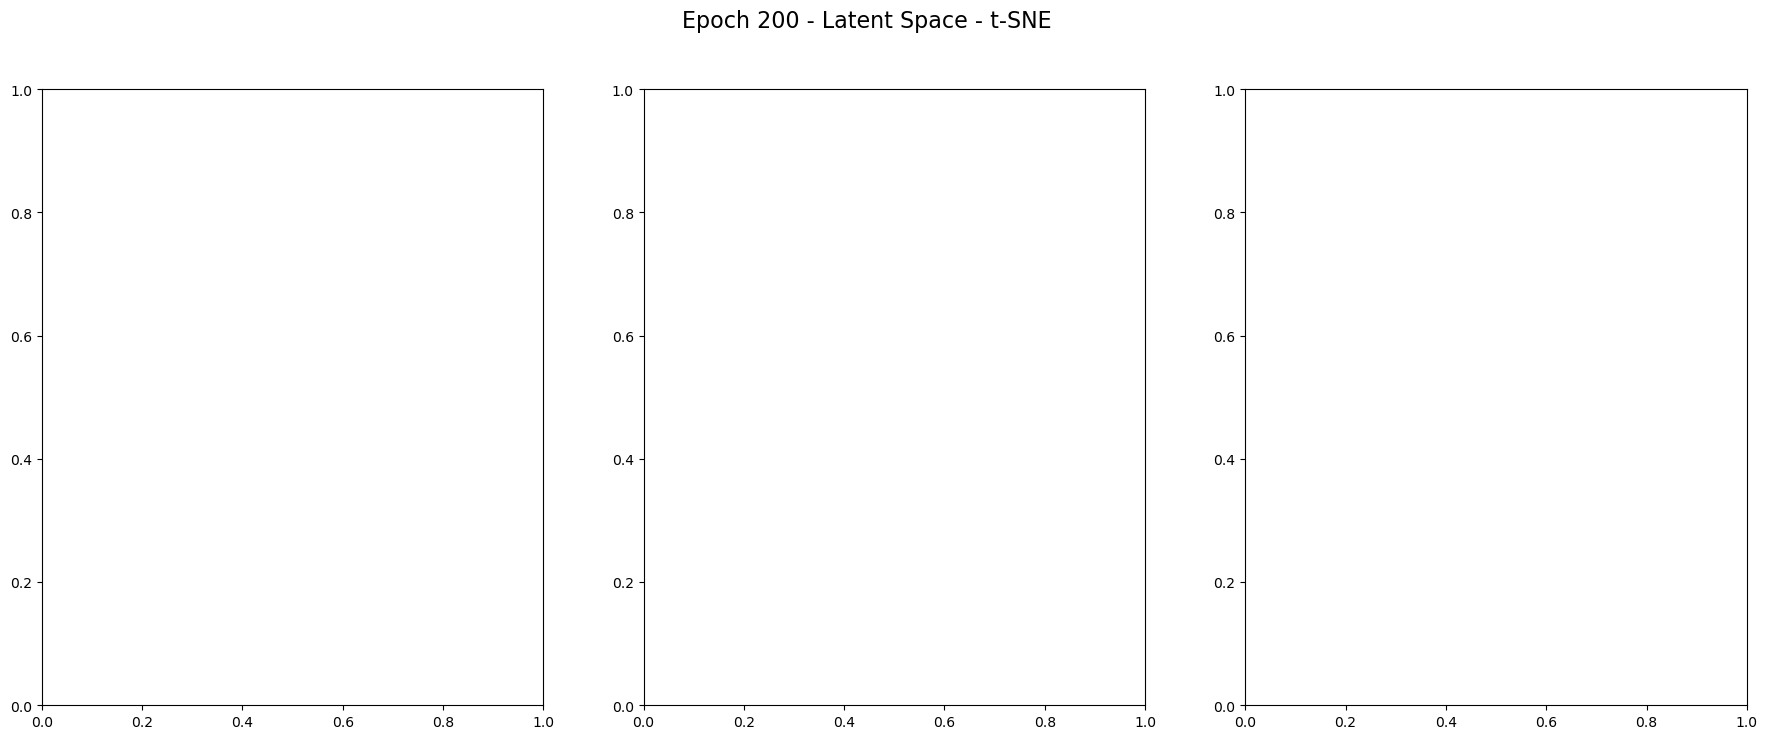

In [3]:
def train_model(train_loader, test_loader, decoder_model, optimizers, 
                          test_rep, n_epochs, first_epoch_gmm=1, 
                          refit_gmm_interval=None, lambda_gmm=1.0, 
                          metrics_list=None, device='cuda', plot_interval=10,
                          use_subset=False, verbose=True):
    """
    Training loop for the decoder-GMM model with separate train and test representation layers.
    
    Parameters:
    ----------
    use_subset: If True, only shows that subset mode is enabled (data subset is handled by IndexedDataset)
    verbose: If True, shows detailed training output with all loss components and timing
    """
    model_optimizer, rep_optimizer, testrep_optimizer = optimizers
    
    train_losses = []
    test_losses = []
    gmm_train_losses = []
    gmm_test_losses = []
    recon_train_losses = []
    recon_test_losses = []
    
    start_time = time.time()
    epoch_times = []  # Track epoch times for better RT calculation
    
    # Get references from the decoder model
    model = decoder_model.decoder
    rep = decoder_model.rep_layer
    gmm = decoder_model.gmm
    
    if verbose:
        print(f"=== Training Configuration ===")
        print(f"Epochs: {n_epochs}")
        print(f"Device: {device}")
        print(f"First GMM epoch: {first_epoch_gmm}")
        print(f"Plot interval: {plot_interval}")
        print(f"Using subset: {use_subset}")
        print(f"Verbose mode: {verbose}")
        print("=" * 30)
    
    def calc_improvement(loss_list):
        # Returns the percentage improvement compared to the previous epoch
        if len(loss_list) < 2:
            return 0.0
        previous = loss_list[-2]
        current = loss_list[-1]
        return ((previous - current) / previous) * 100 if previous != 0 else 0.0
    
    for epoch in range(1, n_epochs + 1):
        epoch_start_time = time.time()
        
        train_losses.append(0)
        test_losses.append(0)
        gmm_train_losses.append(0)
        gmm_test_losses.append(0)
        recon_train_losses.append(0)
        recon_test_losses.append(0)

        # Initialize or refit GMM
        if epoch == 1 and not (first_epoch_gmm == 1):
            if verbose:
                print(f"Initializing GMM at epoch {epoch}...")
            with torch.no_grad():
                representations = rep.z.detach()
                gmm.fit(representations, max_iter=1)
        elif (epoch == first_epoch_gmm) or (refit_gmm_interval and epoch % refit_gmm_interval == 0):
            if verbose:
                print(f"Fitting GMM at epoch {epoch}...")
            with torch.no_grad():
                representations = rep.z.detach()
                gmm = GaussianMixture(
                    n_features=rep.z.shape[1], 
                    n_components=n_components, 
                    covariance_type=covariance_type, 
                    init_params=init_params,
                    device=device, 
                    random_state=RANDOM_STATE, 
                    verbose=verbose and (epoch == first_epoch_gmm), 
                    max_iter=max_iter,
                    tol=tol,
                    n_init=n_init,
                    warm_start=True
                )
                gmm.fit(representations, max_iter=1000)
        elif epoch > first_epoch_gmm:
            if verbose and refit_gmm_interval and epoch % refit_gmm_interval == 0:
                print(f"Updating GMM at epoch {epoch}...")
            with torch.no_grad():
                representations = rep.z.detach()
                gmm.fit(representations, max_iter=100, warm_start=True)

        # Training loop
        model.train()
        rep_optimizer.zero_grad()
        
        for i, (index, x, labels_batch) in enumerate(train_loader):
            model_optimizer.zero_grad()
            
            x, index = x.to(device), index.to(device)

            z = rep(index)
            y = model(z)
            recon_loss = F.mse_loss(y, x, reduction='sum')
            
            # Calculate loss
            if epoch >= first_epoch_gmm and gmm is not None:
                gmm_error = -lambda_gmm * torch.sum(gmm.score_samples(z))
                loss = recon_loss + gmm_error
            else:
                loss = recon_loss
                gmm_error = torch.tensor(0.0).to(device)
            
            # Backpropagation
            loss.backward()
            model_optimizer.step()
            
            # Track losses
            train_losses[-1] += loss.item()
            recon_train_losses[-1] += recon_loss.item()
            if epoch >= first_epoch_gmm:
                gmm_train_losses[-1] += gmm_error.item()
        
        rep_optimizer.step()

        # Testing loop
        model.eval()
        testrep_optimizer.zero_grad()  # Zero out test rep gradients
        
        for i, (index, x, _) in enumerate(test_loader):
            x, index = x.to(device), index.to(device)

            z = test_rep(index)  # Use test_rep
            y = model(z)
            recon_loss = F.mse_loss(y, x, reduction='sum')
            
            # Calculate loss
            if epoch >= first_epoch_gmm and gmm is not None:
                gmm_error = -lambda_gmm * torch.sum(gmm.score_samples(z))
                loss = recon_loss + gmm_error
            else:
                loss = recon_loss
                gmm_error = torch.tensor(0.0).to(device)

            loss.backward()
            
            # Track losses
            test_losses[-1] += loss.item()
            recon_test_losses[-1] += recon_loss.item()
            if epoch >= first_epoch_gmm:
                gmm_test_losses[-1] += gmm_error.item()
        
        testrep_optimizer.step()  # Update test_rep parameters
        
        # Normalize losses by dataset size
        train_losses[-1] /= len(train_loader.dataset)
        test_losses[-1] /= len(test_loader.dataset)
        recon_train_losses[-1] /= len(train_loader.dataset)
        recon_test_losses[-1] /= len(test_loader.dataset)
        gmm_train_losses[-1] /= len(train_loader.dataset)
        gmm_test_losses[-1] /= len(test_loader.dataset)
        
        # Calculate timing information
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)
        
        # Calculate estimated time remaining
        avg_epoch_time = sum(epoch_times) / len(epoch_times)
        remaining_epochs = n_epochs - epoch
        estimated_time_remaining = remaining_epochs * avg_epoch_time
        
        # Format the time for display
        epoch_time_str = str(timedelta(seconds=int(epoch_duration)))
        remaining_time_str = str(timedelta(seconds=int(estimated_time_remaining)))
        
        # Print epoch statistics with configurable verbosity
        if verbose:
            # Detailed output with all components
            print(f"Epoch {epoch}/{n_epochs} "
                  f"[TPE: {epoch_time_str}, RT: {remaining_time_str}]; "
                  f"Train Loss: {train_losses[-1]:.4f} ({calc_improvement(train_losses):.2f}%), "
                  f"Test Loss: {test_losses[-1]:.4f} ({calc_improvement(test_losses):.2f}%), "
                  f"Recon Train: {recon_train_losses[-1]:.4f} ({calc_improvement(recon_train_losses):.2f}%), "
                  f"Recon Test: {recon_test_losses[-1]:.4f} ({calc_improvement(recon_test_losses):.2f}%), "
                  f"GMM Train: {gmm_train_losses[-1]:.4f} ({calc_improvement(gmm_train_losses):.2f}%), "
                  f"GMM Test: {gmm_test_losses[-1]:.4f} ({calc_improvement(gmm_test_losses):.2f}%)")
        else:
            # Compact output
            if epoch % 10 == 0 or epoch == n_epochs:
                print(f"Epoch {epoch}/{n_epochs}: "
                      f"Train={train_losses[-1]:.4f}, Test={test_losses[-1]:.4f}, "
                      f"Time={epoch_time_str}")
        
        # Plot losses at regular intervals (only if verbose or at key epochs)
        if (verbose and (epoch % plot_interval == 0 or epoch == n_epochs)) or \
           (not verbose and epoch == n_epochs):
            plot_training_losses(
                train_losses, test_losses,
                recon_train_losses, recon_test_losses,
                gmm_train_losses, gmm_test_losses,
                title=f"Training Losses at Epoch {epoch}"
            )

        # Plot images and visualizations (reduced frequency for non-verbose)
        plot_this_epoch = (verbose and (epoch % plot_interval == 0 or epoch == n_epochs)) or \
                         (not verbose and (epoch % (plot_interval * 2) == 0 or epoch == n_epochs))
        
        if plot_this_epoch:
            with torch.no_grad():
                # Plot reconstructed training images
                z_train = rep(indices_train.to(device))
                reconstructions_train = model(z_train)
                reconstructions_train = reconstructions_train.cpu()
                plot_images(reconstructions_train, labels_train.cpu(), "Reconstructed Train Images", epoch=epoch)
                
                # Plot reconstructed test images
                z_test = test_rep(indices_test.to(device))
                reconstructions_test = model(z_test)
                reconstructions_test = reconstructions_test.cpu()
                plot_images(reconstructions_test, labels_test.cpu(), "Reconstructed Test Images", epoch=epoch)

                # Plot GMM component reconstructions (only after GMM is fitted)
                if epoch >= first_epoch_gmm and gmm is not None:
                    plot_gmm_images(
                        model, gmm, "GMM Component Means (by weight)",
                        epoch=epoch, top_n=n_components, device=device
                    )
                    plot_gmm_samples(
                        model, gmm, "Generated Images from GMM Samples",
                        n_samples=n_components, epoch=epoch, device=device
                    )

        # Plot latent space visualizations (reduced frequency for weak GPUs)
        if gmm is not None and verbose:
            if epoch % plot_interval == 0 or epoch == n_epochs or epoch == 1 or epoch == first_epoch_gmm:
                with torch.no_grad():
                    z_train = rep.z.detach()
                    z_test = test_rep.z.detach()
                    labels_train = torch.tensor([label for _, _, label in indexed_train_dataset])
                    labels_test = torch.tensor([label for _, _, label in indexed_test_dataset])

                    label_names = [
                        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
                    ]

                    visualizer.visualize(z_train, labels_train, z_test, labels_test, gmm,
                                    method='pca', 
                                    title="Latent Space - PCA",
                                    label_names=label_names,
                                    epoch=epoch)
                    visualizer.visualize(z_train, labels_train, z_test, labels_test, gmm,
                                    method='tsne', 
                                    perplexity=30,
                                    n_iter=1000,
                                    title="Latent Space - t-SNE",
                                    random_state=RANDOM_STATE,
                                    label_names=label_names,
                                    epoch=epoch)
                    visualizer.visualize(z_train, labels_train, z_test, labels_test, gmm,
                                    method='umap',
                                    n_neighbors=20,
                                    n_components=2,
                                    min_dist=0.01,
                                    title="Latent Space - UMAP",
                                    random_state=RANDOM_STATE,
                                    label_names=label_names,
                                    epoch=epoch)
        elif gmm is not None and not verbose:
            # Only show final latent space for non-verbose mode
            if epoch == n_epochs:
                with torch.no_grad():
                    z_train = rep.z.detach()
                    z_test = test_rep.z.detach()
                    labels_train = torch.tensor([label for _, _, label in indexed_train_dataset])
                    labels_test = torch.tensor([label for _, _, label in indexed_test_dataset])

                    label_names = [
                        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
                    ]

                    visualizer.visualize(z_train, labels_train, z_test, labels_test, gmm,
                                    method='pca', 
                                    title="Final Latent Space - PCA",
                                    label_names=label_names,
                                    epoch=epoch)
        
    if verbose:
        total_time = time.time() - start_time
        print(f"\nTraining completed in {str(timedelta(seconds=int(total_time)))}")
        print(f"Final train loss: {train_losses[-1]:.4f}")
        print(f"Final test loss: {test_losses[-1]:.4f}")
    else:
        print(f"Training completed: {train_losses[-1]:.4f} train, {test_losses[-1]:.4f} test")
        
    return decoder_model, rep, test_rep

# Initialize components
nsample_train = len(indexed_train_dataset)
nsample_test = len(indexed_test_dataset)

experiment_name = f"experiment"

# Override the save_figure function to use experiment folder
import src.visualization.visualise as viz_module

# Store the original function ONLY ONCE to avoid recursion
if not hasattr(viz_module, '_original_save_figure'):
    viz_module._original_save_figure = viz_module.save_figure

def save_figure_with_experiment(fig, filename, base_dir=f"figures/{experiment_name}", 
                               subdir=None, dpi=200, format="png", close_fig=True):
    """Modified save_figure that uses experiment folder as base directory."""
    # Use the stored original function to avoid recursion
    return viz_module._original_save_figure(fig, filename, base_dir, subdir, dpi, format, close_fig)

# Replace the save_figure function globally  
viz_module.save_figure = save_figure_with_experiment
# =============================================================================

# GMM Parameters
n_features = 5
n_components = 20
covariance_type = 'diag'
init_params = 'kmeans'
max_iter = 1000
tol = 1e-4
warm_start = True
verbose = False
verbose_interval = 10
n_init = 1

# Representation Layer Parameters
dist = 'uniform_ball'
dist_params_train = {
    "radius": 0.1,
}
dist_params_test = {
    "radius": 0.1,
}

# Decoder Parameters
decoder_hidden_dims = [128, 64, 32]
decoder_output_channels = 1
decoder_output_size = (28, 28)
decoder_activation = 'leaky_relu'
decoder_final_activation = 'sigmoid'
decoder_use_batch_norm = True
decoder_dropout_rate = 0.1
decoder_init_size = (7, 7)

# Training Parameters
epochs = 200
first_epoch_gmm = 50
refit_gmm_interval = 100
lambda_gmm = 1.0

# Representation Layer Optimizer
rep_lr = 0.01

# Decoder Optimizer
decoder_lr = 0.001

# Plotting Parameters
plot_interval = 50

# Create the representation layer
rep = RepresentationLayer(dim=n_features, n_samples=nsample_train, dist=dist, dist_params=dist_params_train, device=device)
test_rep = RepresentationLayer(dim=n_features, n_samples=nsample_test, dist=dist, dist_params=dist_params_test, device=device)

# Create GMM
gmm = GaussianMixture(
    n_features=n_features, 
    n_components=n_components, 
    covariance_type=covariance_type, 
    init_params=init_params,
    device=device, 
    random_state=RANDOM_STATE, 
    verbose=False, 
    max_iter=max_iter,
    tol=tol,
    n_init=n_init,
    warm_start=True
)

# Create the decoder
decoder = ConvDecoder(
    latent_dim=n_features,
    hidden_dims=decoder_hidden_dims,
    output_channels=decoder_output_channels,
    output_size=decoder_output_size,
    use_batch_norm=decoder_use_batch_norm,
    activation=decoder_activation,
    final_activation=decoder_final_activation,
    dropout_rate=decoder_dropout_rate
).to(device)

# Create the full model
decoder_model = DGD(decoder, rep, gmm)

# Count and print parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print parameter counts
decoder_params = count_parameters(decoder)
rep_params = count_parameters(rep)
test_rep_params = count_parameters(test_rep)

print(f"Decoder parameters: {decoder_params:,} ({decoder_params / 1e6:.2f}M)")
print(f"Train representation parameters: {rep_params:,} ({rep_params / 1e6:.2f}M)")
print(f"Test representation parameters: {test_rep_params:,} ({test_rep_params / 1e6:.2f}M)")
print(f"Total trainable parameters: {decoder_params + rep_params + test_rep_params:,} ({(decoder_params + rep_params + test_rep_params) / 1e6:.2f}M)")

# Analyze parameter distribution
print("\nParameter distribution:")
print(f"Decoder: {decoder_params / (decoder_params + rep_params) * 100:.1f}%")
print(f"Train rep: {rep_params / (decoder_params + rep_params) * 100:.1f}%\n")

# Initialize optimizers
decoder_optimizer = torch.optim.AdamW(
    decoder.parameters(),
    lr=decoder_lr,
)
trainrep_optimizer = torch.optim.AdamW(
    rep.parameters(),
    lr=rep_lr,
)
testrep_optimizer = torch.optim.AdamW(
    test_rep.parameters(),
    lr=rep_lr,
)

optimizers = [decoder_optimizer, trainrep_optimizer, testrep_optimizer]

visualizer = LatentSpaceVisualizer()

# Training configuration for weak GPU support
use_subset_mode = use_small_dataset  # Use the existing variable
verbose_mode = True  # Set to False for compact output

trained_model, trained_rep, trained_test_rep = train_model(
    train_loader,
    test_loader,
    decoder_model,
    optimizers,
    test_rep=test_rep,
    n_epochs=epochs,
    first_epoch_gmm=first_epoch_gmm,
    refit_gmm_interval=refit_gmm_interval,
    lambda_gmm=lambda_gmm,
    device=device,
    plot_interval=plot_interval,
)